# Import libraries and get data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
import joblib
import time
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("https://storage.googleapis.com/public-quant/course//content/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Exploratory Data Analysis

## Basics

In [3]:
df.shape

(1338, 7)

In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

There is no missing data, so there is no need to worry about this in the preprocessing part.

In [6]:
df.duplicated().sum()

1

There are duplicates, so we need to remove them in the preprocessing part.

## Visualizations

Text(0.5, 1.0, 'Distribution of charges')

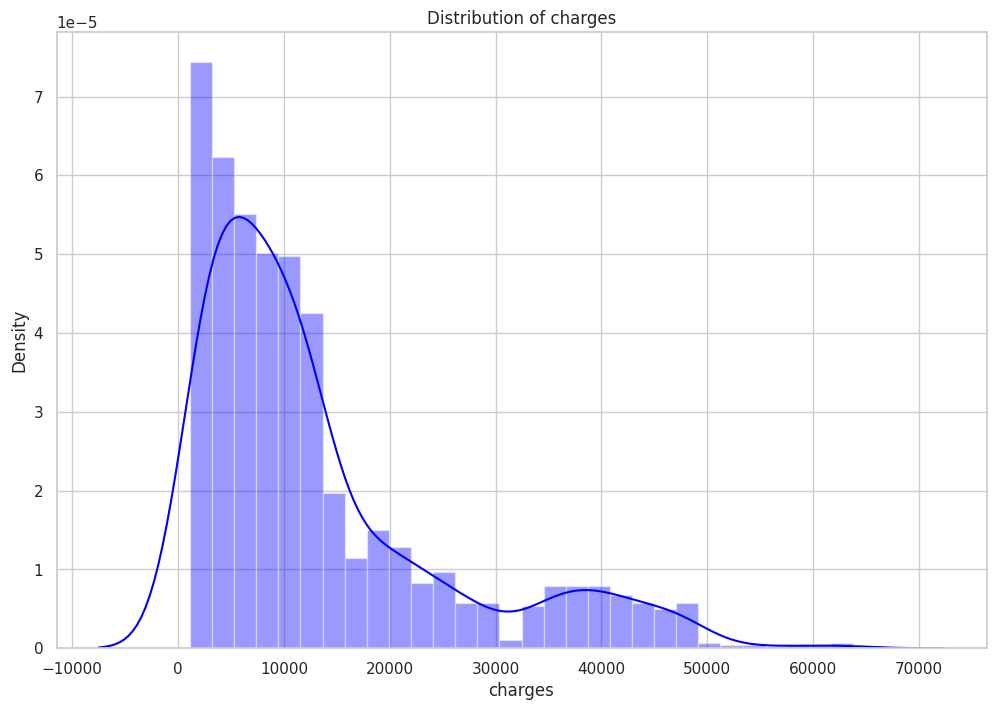

In [7]:
# Distribution of charges
sns.set(style='whitegrid')
f, ax = plt.subplots(1,1, figsize=(12, 8))
ax = sns.distplot(df['charges'], kde = True, color = 'blue')
plt.title('Distribution of charges')

The distribution of "charges" seems to be exponential distribution.

Text(0.5, 1.0, 'Distribution of log(charges)')

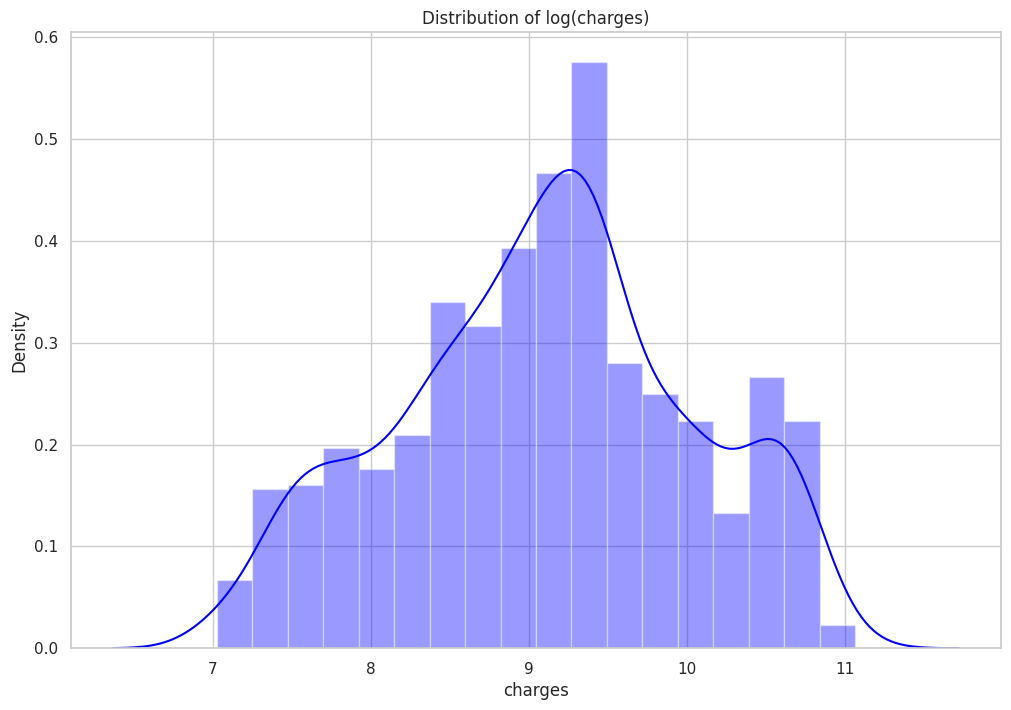

In [8]:
# Distribution of log(charges)
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.distplot(np.log(df['charges']), kde = True, color = 'blue' )
plt.title('Distribution of log(charges)')

After taking log of "charges", the distribution seems to be normal distribution.

Text(0, 0.5, 'charges')

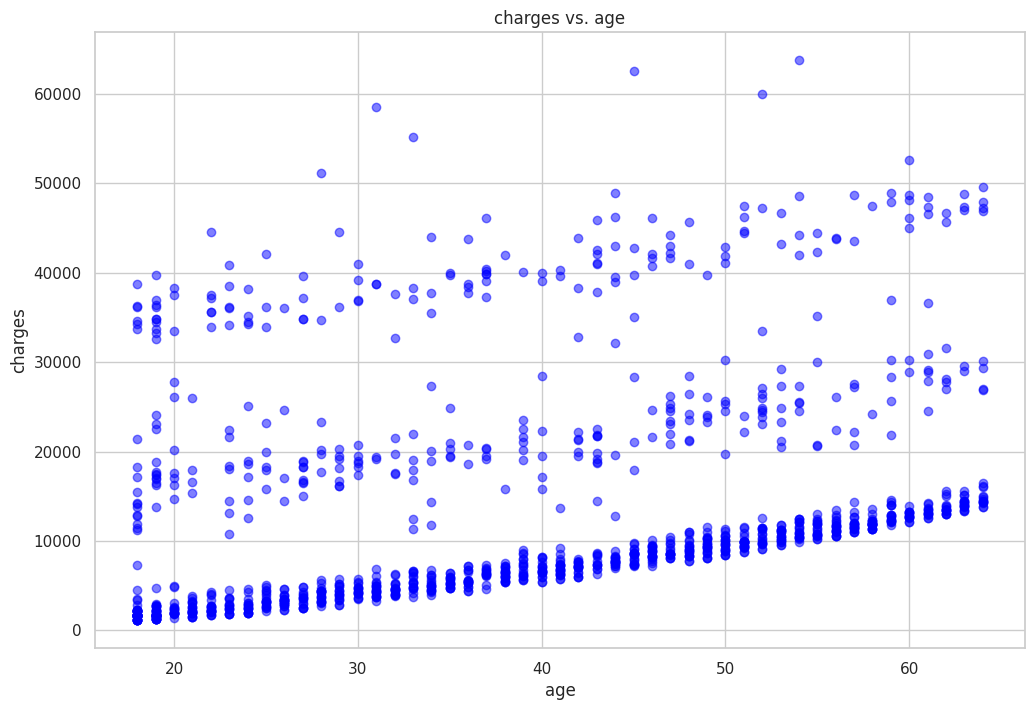

In [9]:
# Charges vs age
plt.figure(figsize=(12, 8))
plt.scatter(df['age'], df['charges'], alpha=0.5, color='blue')
plt.title('charges vs. age')
plt.xlabel('age')
plt.ylabel('charges')

Overall, higher age means higher charge.

Text(0, 0.5, 'charges')

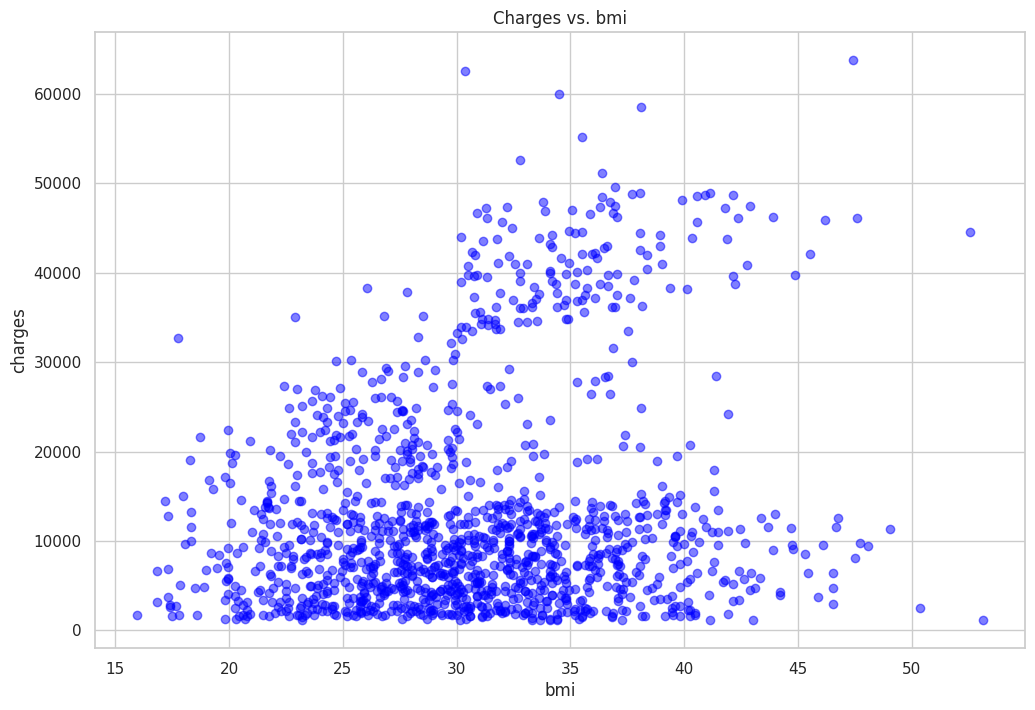

In [10]:
# Charges vs bmi
plt.figure(figsize=(12, 8))
plt.scatter(df['bmi'], df['charges'], alpha=0.5, color='blue')
plt.title('Charges vs. bmi')
plt.xlabel('bmi')
plt.ylabel('charges')

There is a slight positive relationship between charges and bmi, but not obvious.

Text(0.5, 1.0, 'Charges by region')

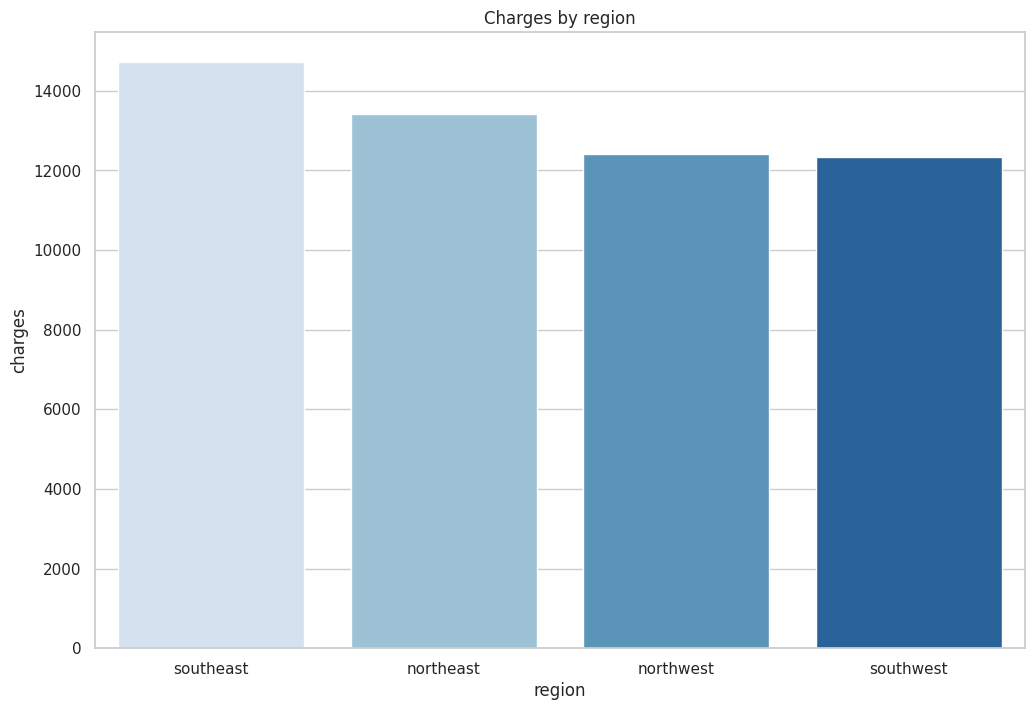

In [11]:
# Charges by region
order = df.groupby("region")["charges"].mean().sort_values(ascending=False).index
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='region', y='charges', data=df, estimator=np.mean, ci=None, palette='Blues', order=order)
plt.title('Charges by region')

The average charge in different regions: southeast > northeast > northwest > southwest

Text(0.5, 1.0, 'Charges by sex')

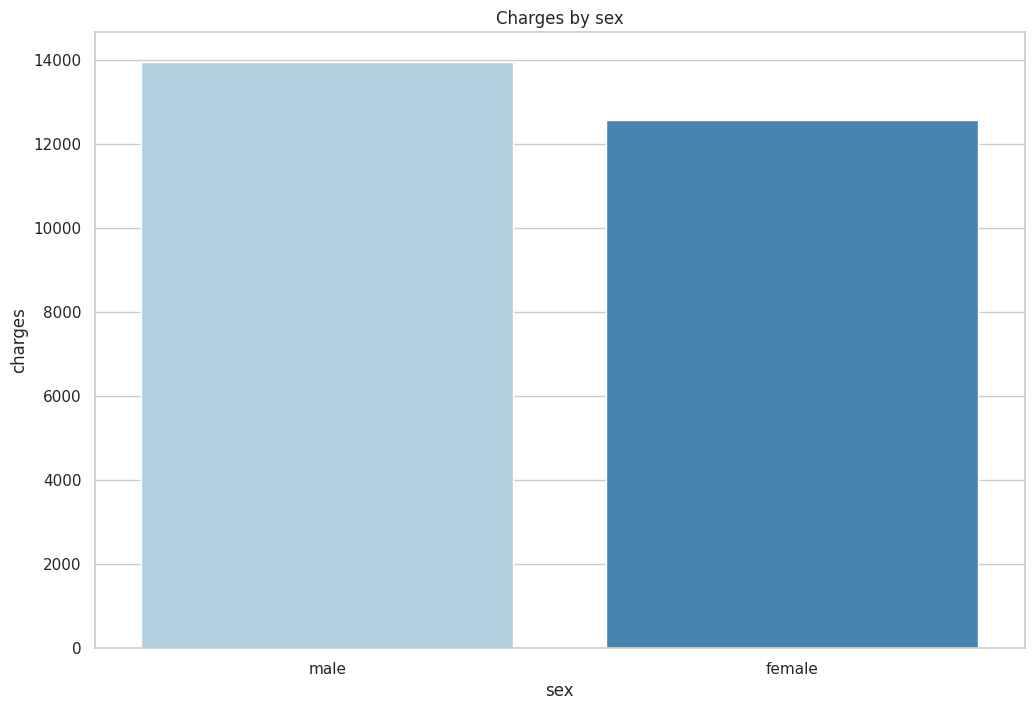

In [12]:
# Charges by sex
order = df.groupby("sex")["charges"].mean().sort_values(ascending=False).index
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='sex', y='charges', data=df, estimator=np.mean, ci=None, palette='Blues', order=order)
plt.title('Charges by sex')

The average charge for male is higher than female.

Text(0.5, 1.0, 'Charges by smoker')

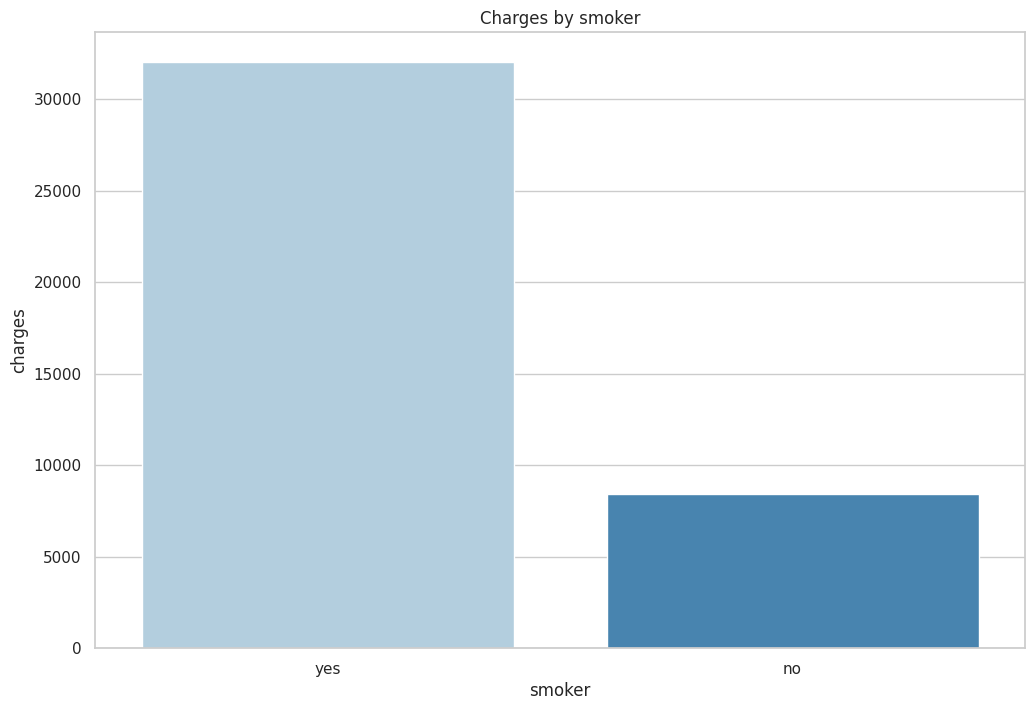

In [13]:
# Charges by smoker
order = df.groupby("smoker")["charges"].mean().sort_values(ascending=False).index
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='smoker', y='charges', data=df, estimator=np.mean, ci=None, palette='Blues', order=order)
plt.title('Charges by smoker')

The average charge for smokers is much higher than non-smokers.

Text(0.5, 1.0, 'Charges by number of children')

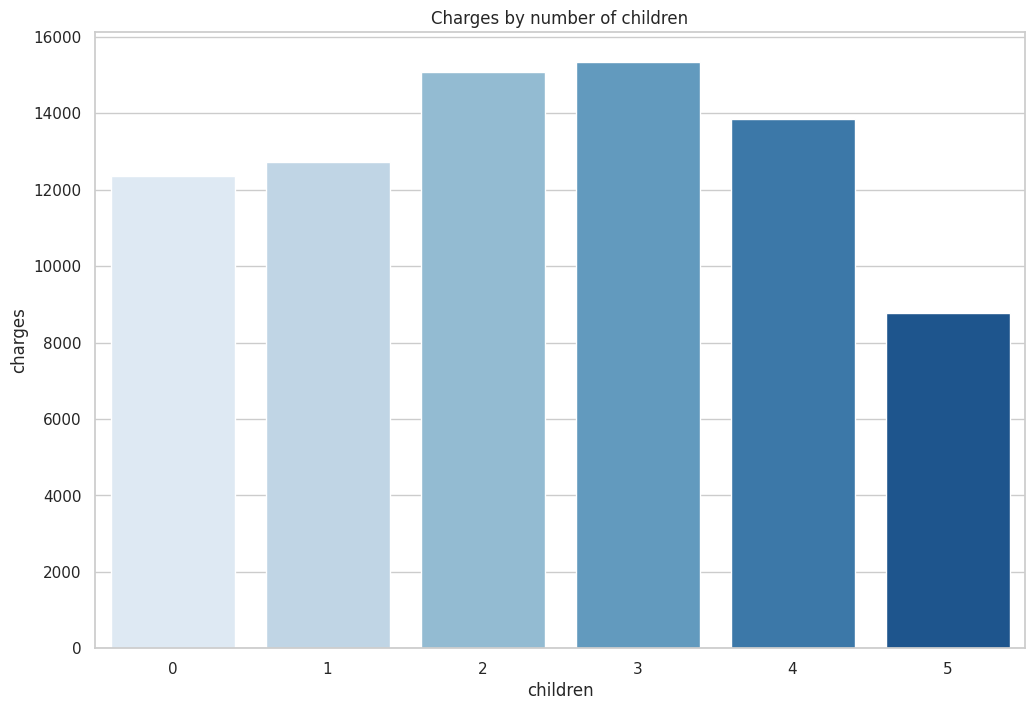

In [14]:
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.barplot(x='children', y='charges', data=df, estimator=np.mean, ci=None, palette='Blues')
plt.title('Charges by number of children')

There is not an obvious relationship between number of children and the average charges.

# Preprocessing of data

## Data wrangling: categorical encoding

In [15]:
# sex: male=1, female=0
df['sex'] = df['sex'].replace({'male': 1, 'female': 0})
# smoker: yes=1, no=0
df['smoker'] = df['smoker'].replace({'yes': 1, 'no': 0})
# region: to four new columns
region_dummies = pd.get_dummies(df['region'], prefix='region')
df = pd.concat([df, region_dummies], axis=1)
df.drop('region', axis=1, inplace=True)

print(df.shape)
df.head()

(1338, 10)


,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


## Data wrangling: check missing data

As checked in the EDA part, there is no missing data.

## Data wrangling: check duplicates

As checked in the EDA part, there are duplicates, so we need to remove them.

In [16]:
df = df.drop_duplicates()
print(df.shape)

(1337, 10)


## Data wrangling: check outlier

In [17]:
numerical_columns = ['age', 'bmi', 'children', 'charges']
for column in numerical_columns:
    minimum = df[column].min()
    maximum = df[column].max()
    print(column, minimum, maximum)

age 18 64
bmi 15.96 53.13
children 0 5
charges 1121.8739 63770.42801


Since the range of [age, bmi, number of children] are reasonable, there is no need to check for outliers.

In [18]:
# code copied from notes
def outlier_detect(data,col,threshold=3,method="IQR"):

    if method == "IQR":
      IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
      Lower_fence = data[col].quantile(0.25) - (IQR * threshold)
      Upper_fence = data[col].quantile(0.75) + (IQR * threshold)
    if method == "STD":
      Upper_fence = data[col].mean() + threshold * data[col].std()
      Lower_fence = data[col].mean() - threshold * data[col].std()
    if method =="MAD":
      median = data[col].median()
      median_absolute_deviation = np.median([np.abs(y - median) for y in data[col]])
      modified_z_scores = pd.Series([0.6745 * (y - median) / median_absolute_deviation for y in data[col]])
      outlier_index = np.abs(modified_z_scores) > threshold
      print('Num of outlier detected:',outlier_index.value_counts()[1])
      print('Proportion of outlier detected',outlier_index.value_counts()[1]/len(outlier_index))
      return outlier_index, (median_absolute_deviation, median_absolute_deviation)

    para = (Upper_fence, Lower_fence)
    tmp = pd.concat([data[col]>Upper_fence,data[col]<Lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    print('Num of outlier detected:',outlier_index.value_counts()[1])
    print('Proportion of outlier detected',outlier_index.value_counts()[1]/len(outlier_index))

    return outlier_index, para

In [19]:
index,para = outlier_detect(df,'charges',threshold=0.5,method="IQR")
print('Upper bound:',para[0],'\nLower bound:',para[1])

Num of outlier detected: 230
Proportion of outlier detected 0.17202692595362754
Upper bound: 22613.404175 
Lower bound: -1209.3427249999995


The insurance charges column is exponentially distributed, so it is also normal to have "outliers". There is no need to remove or replace them.

## Data augmentation: log

As seen in the EDA part, "charges" is exponentially distributed, and we need to take log of it.

In [20]:
# Take log of insurance charges
df['charges_log'] = np.log(df['charges'])
df.drop('charges', axis=1, inplace=True)
df.head()

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest,charges_log
0,19,0,27.900,0,1,0,0,0,1,9.734176
1,18,1,33.770,1,0,0,0,1,0,7.453302
2,28,1,33.000,3,0,0,0,1,0,8.400538
3,33,1,22.705,0,0,0,1,0,0,9.998092
4,32,1,28.880,0,0,0,1,0,0,8.260197


## Train/test split

In [21]:
from sklearn.model_selection import train_test_split
x = df.drop(['charges_log'], axis = 1)
y = df['charges_log']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

print("Training set size:")
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")

print("Test set size:")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")


Training set size:
x_train: (1069, 9), y_train: (1069,)
Test set size:
x_test: (268, 9), y_test: (268,)


## Data augmentation: scale

In [22]:
from sklearn.preprocessing import StandardScaler

xscaler = StandardScaler()
xscaler.fit(x_train)
x_train_scaled = xscaler.transform(x_train)
x_test_scaled = xscaler.transform(x_test)
joblib.dump(xscaler,'xscalar.save')

yscaler = StandardScaler()
y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)
yscaler.fit(y_train_reshaped)
y_train_scaled = yscaler.transform(y_train_reshaped)
y_test_scaled = yscaler.transform(y_test_reshaped)
joblib.dump(yscaler, 'yscaler.save')

['yscaler.save']

# Model 1: KNN

Before start, first create a dictionary that stores all RMSE values and runtime.

In [23]:
rmse_dict = {}
time_dict = {}

## Model building: cross validation

In [24]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from math import sqrt
from sklearn.metrics import mean_squared_error

length = round(sqrt(x_train_scaled.shape[0]))
print(length)
rmse_results_cv = {'uniform': [], 'distance': []}
min_rmse_cv = float('inf')
min_k_cv = None
min_weight_cv = ''

33


In [25]:
start = time.time()
weights_options = ['uniform', 'distance']

for weight in weights_options:
    for k in range(1, length + 1):
        knn = KNeighborsRegressor(n_neighbors=k, weights=weight)
        # Perform 5-fold cross-validation
        scores = cross_val_score(knn, x_train_scaled, y_train_scaled.ravel(), cv=5, scoring='neg_mean_squared_error')
        rmse_cv = np.sqrt(-scores.mean())
        print(f"Weight: {weight}, k = {k}: Cross-Validated Root Mean Squared Error = {rmse_cv}")
        rmse_results_cv[weight].append(rmse_cv)
        if rmse_cv < min_rmse_cv:
            min_rmse_cv = rmse_cv
            min_k_cv = k
            min_weight_cv = weight
end = time.time()

Weight: uniform, k = 1: Cross-Validated Root Mean Squared Error = 0.5954444115088711
Weight: uniform, k = 2: Cross-Validated Root Mean Squared Error = 0.5312996371874674
Weight: uniform, k = 3: Cross-Validated Root Mean Squared Error = 0.51130027803727
Weight: uniform, k = 4: Cross-Validated Root Mean Squared Error = 0.4965032817913246
Weight: uniform, k = 5: Cross-Validated Root Mean Squared Error = 0.4880104280064585
Weight: uniform, k = 6: Cross-Validated Root Mean Squared Error = 0.4802906909018075
Weight: uniform, k = 7: Cross-Validated Root Mean Squared Error = 0.474375534601684
Weight: uniform, k = 8: Cross-Validated Root Mean Squared Error = 0.47393666049549243
Weight: uniform, k = 9: Cross-Validated Root Mean Squared Error = 0.47328690662292594
Weight: uniform, k = 10: Cross-Validated Root Mean Squared Error = 0.4747754054806352
Weight: uniform, k = 11: Cross-Validated Root Mean Squared Error = 0.47562223802317455
Weight: uniform, k = 12: Cross-Validated Root Mean Squared Erro

## Model performance

In [26]:
rmse_knn = min_rmse_cv
print(f"Best Model: Weight = {min_weight_cv}, k = {min_k_cv}, with minimum RMSE = {rmse_knn}")
rmse_dict['KNN (Best)'] = rmse_knn

Best Model: Weight = uniform, k = 9, with minimum RMSE = 0.47328690662292594


In [27]:
time_knn = end - start
print(f"Total running time: {time_knn} seconds")
time_dict['KNN (Best)'] = time_knn

Total running time: 6.10406494140625 seconds


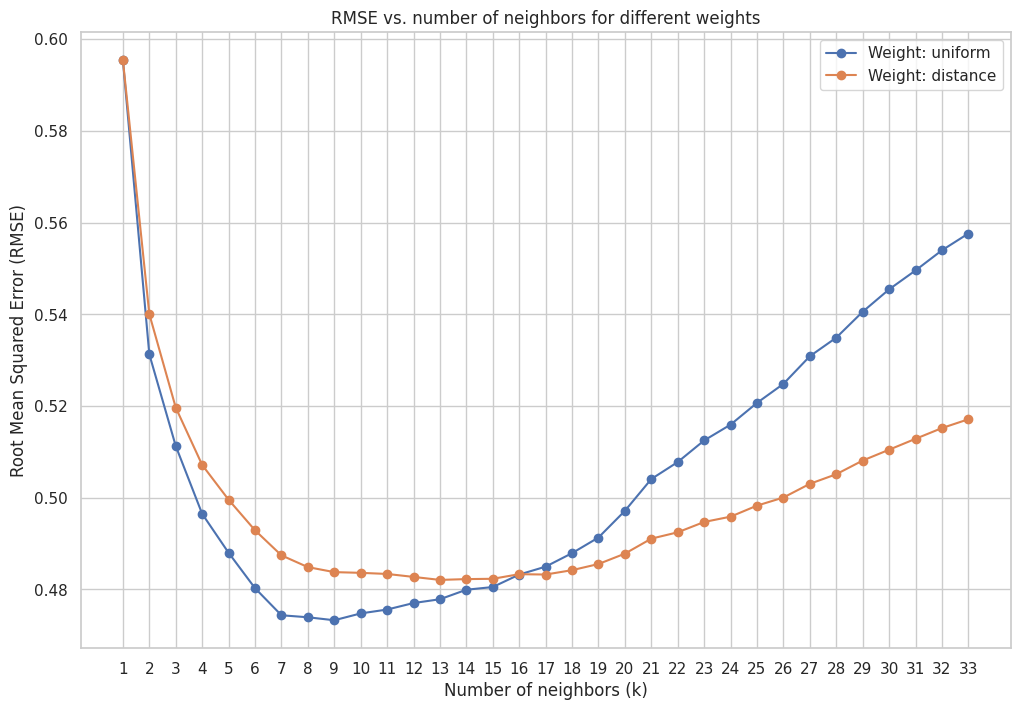

In [28]:
plt.figure(figsize=(12, 8))

for weight, rmses_cv in rmse_results_cv.items():
    plt.plot(range(1, length + 1), rmses_cv, marker='o', linestyle='-', label=f'Weight: {weight}')

plt.title('RMSE vs. number of neighbors for different weights')
plt.xlabel('Number of neighbors (k)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xticks(range(1, length + 1))
plt.legend()
plt.grid(True)

Analysis:

When number of neighbors is vey small or very large, the model has larger RMSE.

When number of neighbors is small, using "uniform" weight performs better. When number of neighbors is large, using "distance" weight performs better.

The best Model is using "uniform" weight and k = 9, with RMSE = 0.473.

# Model 2: Linear regression

## Model building

In [29]:
from sklearn.linear_model import LinearRegression
start = time.time()
# Initialize the Linear Regression Model
Linear = LinearRegression()
# Fit the Model to the Training Data
Linear.fit(x_train_scaled, y_train_scaled)
# Make Predictions
y_pred_linear = Linear.predict(x_test_scaled)
end = time.time()

## Model performance: feature importance

In [30]:
mse_linear = mean_squared_error(y_test_scaled, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
print(f"Linear Regression RMSE: {rmse_linear}")
rmse_dict['Linear Regression (Basic)'] = rmse_linear

Linear Regression RMSE: 0.4977476403713619


In [31]:
print(rmse_dict)

{'KNN (Best)': 0.47328690662292594, 'Linear Regression (Basic)': 0.4977476403713619}


In [32]:
time_linear = end - start
print(f"Total running time: {time_linear} seconds")
time_dict['Linear Regression (Basic)'] = time_linear

Total running time: 0.02073955535888672 seconds


In [33]:
print(time_dict)

{'KNN (Best)': 6.10406494140625, 'Linear Regression (Basic)': 0.02073955535888672}


In [34]:
feature_names = x_train.columns

print("Linear Regression coefficients:")
for i, coef in enumerate(Linear.coef_[0]):
    print(f"{feature_names[i]}: {coef}")

print(f"Intercept: {Linear.intercept_}")

Linear Regression coefficients:
age: 0.5298058838266227
sex: -0.034076719643150434
bmi: 0.08551091232526763
children: 0.13331502209138418
smoker: 0.6852119769503466
region_northeast: 0.04164970281002418
region_northwest: 0.006776370471008186
region_southeast: -0.03145704871733781
region_southwest: -0.015669395688809106
Intercept: [-1.59902468e-15]


Text(0.5, 1.0, 'Linear Regression Feature Importance')

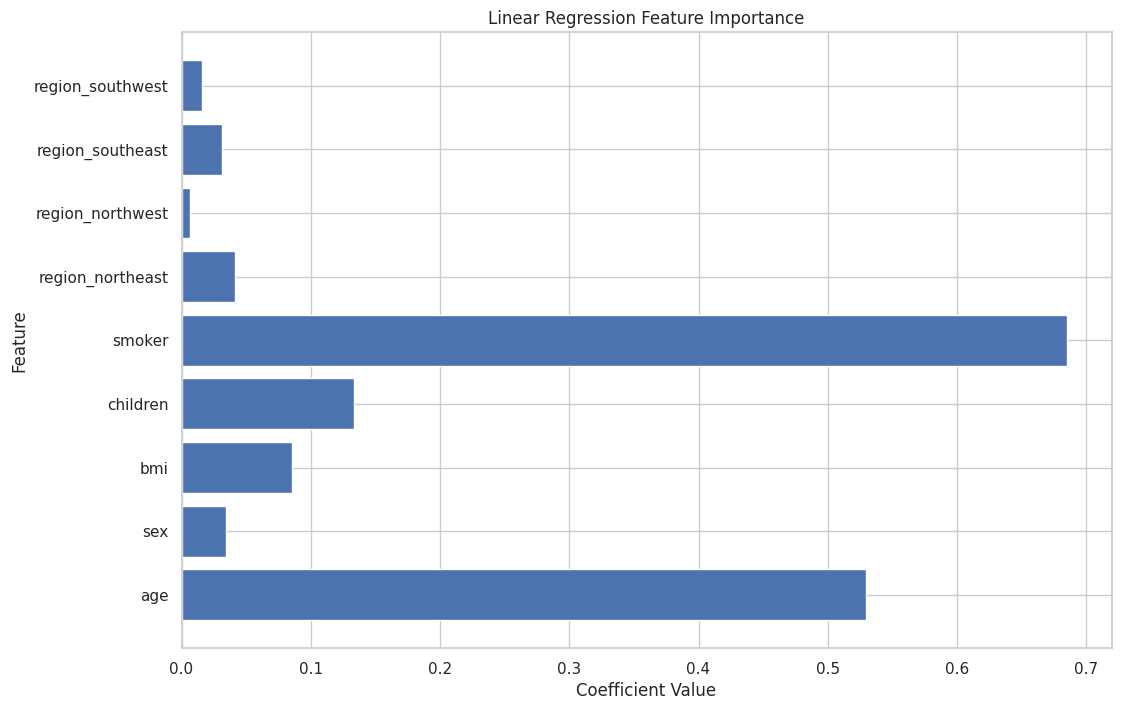

In [35]:
coefficients = Linear.coef_[0]

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(feature_names, abs(coefficients))
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Linear Regression Feature Importance')

The outcome of the feature importance analysis aligns closely with the insights gained during the initial EDA:

1. The 'region' feature appears to have minimal impact on the model's prediction.

2. 'Smoker' and 'age' features are significantly more influential.

Moving forward, I plan to apply backward elimination for feature selection. The goal is to identify a streamlined model that maintains, or even improves, accuracy by focusing on the most critical predictors.

## Model building: Backward Elimination feature selection with Cross Validation

In [36]:
# Function to calculate RMSE using cross-validation
def calculate_cv_rmse(X, y, feature_indices, cv=5):
    model = LinearRegression()
    # Use slicing to select only the columns of the current subset of features
    scores = cross_val_score(model, X[:, feature_indices], y, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)  # Convert from negative MSE to RMSE
    return np.mean(rmse_scores)  # Return the average RMSE across all folds

# Initial setup
features = list(x_train.columns)  # Assuming x_train is your initial DataFrame before scaling
feature_indices = list(range(x_train_scaled.shape[1]))  # List of all feature indices
min_rmse = np.inf  # Initialize to infinity
best_features_indices = feature_indices[:]  # Start with all features

start = time.time()
# Backward elimination with cross-validation
for _ in range(len(features)):
    improvement_found = False
    feature_to_remove = -1

    for i in feature_indices:
        temp_features = [idx for idx in feature_indices if idx != i]  # Create a list excluding the current feature
        temp_rmse = calculate_cv_rmse(x_train_scaled, y_train_scaled, temp_features)

        if temp_rmse < min_rmse:
            min_rmse = temp_rmse
            feature_to_remove = i
            improvement_found = True

    if improvement_found and feature_to_remove != -1:
        print(f"Removing feature index {feature_to_remove} improved CV RMSE to {min_rmse}")
        feature_indices.remove(feature_to_remove)  # Remove the feature that improved RMSE
    else:
        break  # Exit loop if no improvement

end = time.time()
# Final selected features
best_features_names = [features[i] for i in feature_indices]

Removing feature index 6 improved CV RMSE to 0.4861103318073174
Removing feature index 8 improved CV RMSE to 0.48610668259607354


## Model performance

In [37]:
print("Selected Features after Backward Elimination with Cross-Validation:", best_features_names)
rmse_linear_best = min_rmse
print("Minimum CV RMSE achieved:", rmse_linear_best)
rmse_dict['Linear Regression (Best)'] = rmse_linear_best

Selected Features after Backward Elimination with Cross-Validation: ['age', 'sex', 'bmi', 'children', 'smoker', 'region_northeast', 'region_southeast']
Minimum CV RMSE achieved: 0.48610668259607354


The features dropped by backward elimination are two of the regions (northwest and southwest).

In [38]:
print(rmse_dict)

{'KNN (Best)': 0.47328690662292594, 'Linear Regression (Basic)': 0.4977476403713619, 'Linear Regression (Best)': 0.48610668259607354}


In [39]:
time_linear_best = end - start
print(f"Total running time: {time_linear_best} seconds")
time_dict['Linear Regression (Best)'] = time_linear_best

Total running time: 0.7364132404327393 seconds


In [40]:
print(time_dict)

{'KNN (Best)': 6.10406494140625, 'Linear Regression (Basic)': 0.02073955535888672, 'Linear Regression (Best)': 0.7364132404327393}


The backward elimination process with cross-validation removed 2 of the regions that might contribute little to the model. The minimum cross-validated Root Mean Squared Error (RMSE) achieved with this subset is 0.4861, which is an improvement over the original Linear Regression RMSE of 0.4977 obtained using all features. This improvement suggests that the feature selection process has successfully enhanced the model's efficiency and potentially its generalization ability, although the enhancement is slight.

# Model 3: Ridge Regression

## Model building: different alpha

In [41]:
from sklearn.linear_model import Ridge

alphas = np.logspace(-4, 0, 50)  # Logarithmically spaced alphas between 0.0001 and 1
best_alpha = None
min_rmse = np.inf

rmse_scores = []

start = time.time()
# Loop over the alphas to find the best one
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(x_train_scaled, y_train_scaled)
    y_pred_ridge = ridge.predict(x_test_scaled)
    mse_ridge = mean_squared_error(y_test_scaled, y_pred_ridge)
    rmse_ridge = np.sqrt(mse_ridge)
    rmse_scores.append(rmse_ridge)

    if rmse_ridge < min_rmse:
        min_rmse = rmse_ridge
        best_alpha = alpha
end = time.time()

## Model performance

In [42]:
print(f"Best Ridge Regression alpha: {best_alpha}")
rmse_ridge = min_rmse
print(f"Ridge Regression RMSE with best alpha: {rmse_ridge}")
rmse_dict['Ridge Regression (Basic)'] = rmse_ridge

Best Ridge Regression alpha: 0.0001
Ridge Regression RMSE with best alpha: 0.49774764358210977


In [43]:
print(rmse_dict)

{'KNN (Best)': 0.47328690662292594, 'Linear Regression (Basic)': 0.4977476403713619, 'Linear Regression (Best)': 0.48610668259607354, 'Ridge Regression (Basic)': 0.49774764358210977}


In [44]:
time_ridge = end - start
print(f"Total running time: {time_ridge} seconds")
time_dict['Ridge Regression (Basic)'] = time_ridge

Total running time: 0.38298583030700684 seconds


In [45]:
print(time_dict)

{'KNN (Best)': 6.10406494140625, 'Linear Regression (Basic)': 0.02073955535888672, 'Linear Regression (Best)': 0.7364132404327393, 'Ridge Regression (Basic)': 0.38298583030700684}


Text(0.5, 1.0, 'Ridge Regression RMSE vs. Alpha')

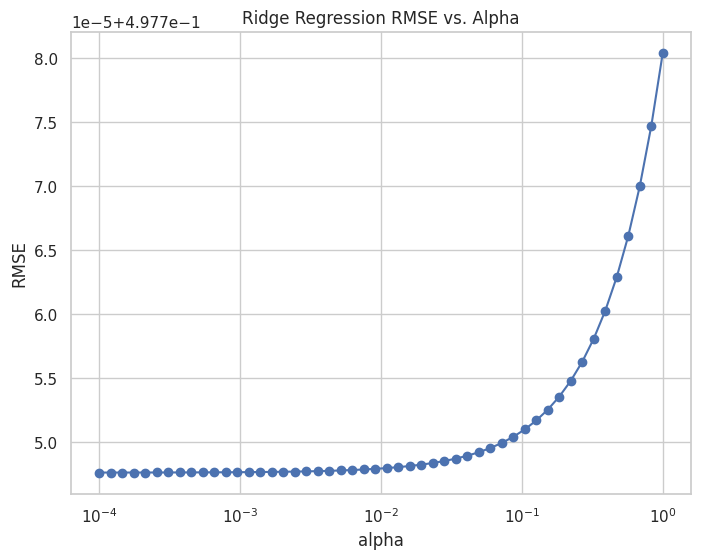

In [46]:
plt.figure(figsize=(8, 6))
plt.plot(alphas, rmse_scores, marker='o')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.title('Ridge Regression RMSE vs. Alpha')

This gives us a Ridge Regression model with very small alpha, so it is almost the same as the linear regression model we got earlier. Simple Linear Regression is already performing well, and the introduction of L2 regularization with a small alpha does not significantly alter the model's predictive accuracy. More complex models or regularization techniques are not always necessary or beneficial, especially when the simpler models are well-suited to the data's underlying structure.

Here I skip feature importance analysis, since it would be mostly the same as what we have seen in linear regression part.

## Model building: Backward Elimination feature selection with Cross Validation

In [47]:
from sklearn.linear_model import RidgeCV

# Define a range of alpha values for RidgeCV to explore
alphas = np.logspace(-6, 6, 13)

# Function to calculate RMSE using cross-validation, adapted for RidgeCV
def calculate_cv_rmse_ridge(X, y, feature_indices, alphas, cv=5):
    model = RidgeCV(alphas=alphas, cv=cv, scoring='neg_mean_squared_error')
    scores = cross_val_score(model, X[:, feature_indices], y, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)  # Convert from negative MSE to RMSE
    return np.mean(rmse_scores)  # Return the average RMSE across all folds

# Initialize variables for backward elimination process
features = list(x_train.columns)  # List of feature names
feature_indices = list(range(x_train_scaled.shape[1]))  # Indices of features
min_rmse = np.inf  # Initialize min_rmse with infinity
best_features_indices = feature_indices[:]  # Copy of all feature indices

start = time.time()
# Backward elimination process
for _ in range(len(features)):
    improvement_found = False
    feature_to_remove = -1

    for i in feature_indices:
        temp_features = [idx for idx in feature_indices if idx != i]  # Create a list excluding the current feature
        temp_rmse = calculate_cv_rmse_ridge(x_train_scaled, y_train_scaled, temp_features, alphas)

        if temp_rmse < min_rmse:
            min_rmse = temp_rmse
            feature_to_remove = i
            improvement_found = True

    if improvement_found and feature_to_remove != -1:
        print(f"Removing feature index {feature_to_remove} improved CV RMSE to {min_rmse}")
        feature_indices.remove(feature_to_remove)  # Remove the feature that improved RMSE
    else:
        break  # Exit loop if no improvement

end = time.time()
# Mapping back to feature names
best_features_names = [features[i] for i in feature_indices]

Removing feature index 7 improved CV RMSE to 0.48611696628460976
Removing feature index 8 improved CV RMSE to 0.48599024582799044


## Model performance

In [48]:
print("Selected Features after Backward Elimination with RidgeCV:", best_features_names)
rmse_ridge_best = min_rmse
print("Minimum CV RMSE achieved:", rmse_ridge_best)
rmse_dict['Ridge Regression (Best)'] = rmse_ridge_best

Selected Features after Backward Elimination with RidgeCV: ['age', 'sex', 'bmi', 'children', 'smoker', 'region_northeast', 'region_northwest']
Minimum CV RMSE achieved: 0.48599024582799044


The features dropped by backward elimination is also two of the regions (southeast and southwest), although different from linear regession.

In [49]:
print(rmse_dict)

{'KNN (Best)': 0.47328690662292594, 'Linear Regression (Basic)': 0.4977476403713619, 'Linear Regression (Best)': 0.48610668259607354, 'Ridge Regression (Basic)': 0.49774764358210977, 'Ridge Regression (Best)': 0.48599024582799044}


In [50]:
time_ridge_best = end - start
print(f"Total running time: {time_ridge_best} seconds")
time_dict['Ridge Regression (Best)'] = time_ridge_best

Total running time: 21.381205797195435 seconds


In [51]:
print(time_dict)

{'KNN (Best)': 6.10406494140625, 'Linear Regression (Basic)': 0.02073955535888672, 'Linear Regression (Best)': 0.7364132404327393, 'Ridge Regression (Basic)': 0.38298583030700684, 'Ridge Regression (Best)': 21.381205797195435}


After applying backward elimination feature selection and cross validation, the performance of ridge regression become better, getting a smaller RMSE (at a cost of using more time). The RMSE value is also smaller than that of linear regression with the same setting.

# Model 4: Lasso Regression

## Model building: different alpha

In [52]:
from sklearn.linear_model import Lasso

alphas = np.logspace(-4, 0, 50)  # Logarithmically spaced alphas between 0.0001 and 1
best_alpha = None
min_rmse = np.inf

rmse_scores = []

start = time.time()
# Loop over the alphas to find the best one
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(x_train_scaled, y_train_scaled)
    y_pred_lasso = lasso.predict(x_test_scaled)
    mse_lasso = mean_squared_error(y_test_scaled, y_pred_lasso)
    rmse_lasso = np.sqrt(mse_lasso)
    rmse_scores.append(rmse_lasso)

    if rmse_lasso < min_rmse:
        min_rmse = rmse_lasso
        best_alpha = alpha
end = time.time()

## Model performance

In [53]:
print(f"Best Lasso Regression alpha: {best_alpha}")
rmse_lasso = min_rmse
print(f"Lasso Regression RMSE with best alpha: {rmse_lasso}")
rmse_dict['Lasso Regression (Basic)'] = rmse_lasso

Best Lasso Regression alpha: 0.0001
Lasso Regression RMSE with best alpha: 0.49777333349650704


In [54]:
print(rmse_dict)

{'KNN (Best)': 0.47328690662292594, 'Linear Regression (Basic)': 0.4977476403713619, 'Linear Regression (Best)': 0.48610668259607354, 'Ridge Regression (Basic)': 0.49774764358210977, 'Ridge Regression (Best)': 0.48599024582799044, 'Lasso Regression (Basic)': 0.49777333349650704}


In [55]:
time_lasso = end - start
print(f"Total running time: {time_lasso} seconds")
time_dict['Lasso Regression (Basic)'] = time_lasso

Total running time: 0.08808469772338867 seconds


In [56]:
print(time_dict)

{'KNN (Best)': 6.10406494140625, 'Linear Regression (Basic)': 0.02073955535888672, 'Linear Regression (Best)': 0.7364132404327393, 'Ridge Regression (Basic)': 0.38298583030700684, 'Ridge Regression (Best)': 21.381205797195435, 'Lasso Regression (Basic)': 0.08808469772338867}


Text(0.5, 1.0, 'Lasso Regression RMSE vs. Alpha')

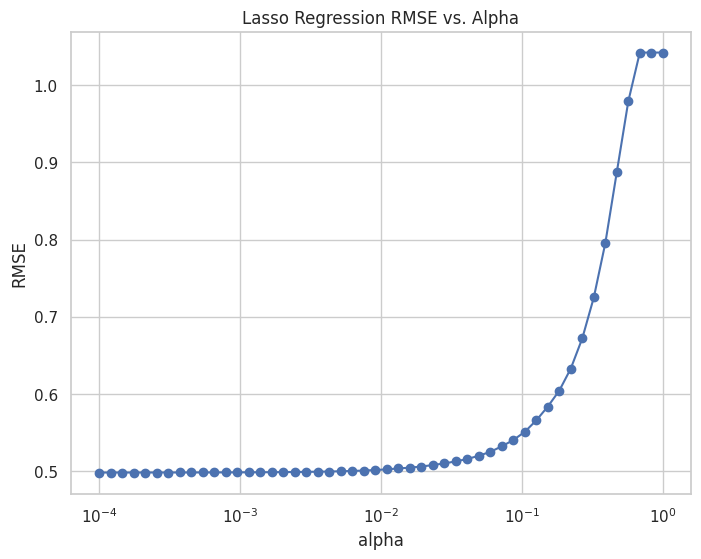

In [57]:
plt.figure(figsize=(8, 6))
plt.plot(alphas, rmse_scores, marker='o')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.title('Lasso Regression RMSE vs. Alpha')

Similar to Ridge Regression, Lasso Rigression also gives us a model with very small alpha, so it is almost the same as the linear regression model we got earlier. Simple Linear Regression is already performing well, and the introduction of L1 regularization with a small alpha does not significantly alter the model's predictive accuracy. More complex models or regularization techniques are not always necessary or beneficial, especially when the simpler models are well-suited to the data's underlying structure.

Here, I also skip feature importance analysis, since it would be mostly the same as what we have seen in linear regression part.

## Model building: Backward Elimination feature selection with Cross Validation

In [58]:
from sklearn.linear_model import LassoCV

# Define a range of alpha values for LassoCV to explore
alphas = np.logspace(-6, 6, 13)

# Function to calculate RMSE using cross-validation, adapted for LassoCV
def calculate_cv_rmse_lasso(X, y, feature_indices, alphas, cv=5):
    model = LassoCV(alphas=alphas, cv=cv)
    scores = cross_val_score(model, X[:, feature_indices], y, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)  # Convert from negative MSE to RMSE
    return np.mean(rmse_scores)  # Return the average RMSE across all folds

# Initialize variables for backward elimination process
features = list(x_train.columns)  # List of feature names
feature_indices = list(range(x_train_scaled.shape[1]))  # Indices of features
min_rmse = np.inf  # Initialize min_rmse with infinity
best_features_indices = feature_indices[:]  # Copy of all feature indices

start = time.time()
# Backward elimination process
for _ in range(len(features)):
    improvement_found = False
    feature_to_remove = -1

    for i in feature_indices:
        temp_features = [idx for idx in feature_indices if idx != i]  # Create a list excluding the current feature
        temp_rmse = calculate_cv_rmse_lasso(x_train_scaled, y_train_scaled, temp_features, alphas)

        if temp_rmse < min_rmse:
            min_rmse = temp_rmse
            feature_to_remove = i
            improvement_found = True

    if improvement_found and feature_to_remove != -1:
        print(f"Removing feature index {feature_to_remove} improved CV RMSE to {min_rmse}")
        feature_indices.remove(feature_to_remove)  # Remove the feature that improved RMSE
    else:
        break  # Exit loop if no improvement

end = time.time()
# Mapping back to feature names
best_features_names = [features[i] for i in feature_indices]

Removing feature index 6 improved CV RMSE to 0.48611088339652575
Removing feature index 8 improved CV RMSE to 0.4861066910021624


## Model performance

In [59]:
print("Selected Features after Backward Elimination with LassoCV:", best_features_names)
rmse_lasso_best = min_rmse
print("Minimum CV RMSE achieved:", rmse_lasso_best)
rmse_dict['Lasso Regression (Best)'] = rmse_lasso_best

Selected Features after Backward Elimination with LassoCV: ['age', 'sex', 'bmi', 'children', 'smoker', 'region_northeast', 'region_southeast']
Minimum CV RMSE achieved: 0.4861066910021624


The features dropped by backward elimination is also two of the regions, same as linear regression (northwest and southwest), but different from ridge regression.

In [60]:
print(rmse_dict)

{'KNN (Best)': 0.47328690662292594, 'Linear Regression (Basic)': 0.4977476403713619, 'Linear Regression (Best)': 0.48610668259607354, 'Ridge Regression (Basic)': 0.49774764358210977, 'Ridge Regression (Best)': 0.48599024582799044, 'Lasso Regression (Basic)': 0.49777333349650704, 'Lasso Regression (Best)': 0.4861066910021624}


In [61]:
time_lasso_best = end - start
print(f"Total running time: {time_lasso_best} seconds")
time_dict['Lasso Regression (Best)'] = time_lasso_best

Total running time: 1.701885461807251 seconds


In [62]:
print(time_dict)

{'KNN (Best)': 6.10406494140625, 'Linear Regression (Basic)': 0.02073955535888672, 'Linear Regression (Best)': 0.7364132404327393, 'Ridge Regression (Basic)': 0.38298583030700684, 'Ridge Regression (Best)': 21.381205797195435, 'Lasso Regression (Basic)': 0.08808469772338867, 'Lasso Regression (Best)': 1.701885461807251}


After applying backward elimination feature selection and cross validation, the performance of lasso regression become better, getting a smaller RMSE (at a cost of using more time).

The RMSE value is same as linear regression, and larger than ridge regression. L1 for Lasso, which can zero out coefficients, versus L2 for Ridge, which only shrinks them. The slight superiority of Ridge in this case may indicate that shrinking coefficients without eliminating them (as Ridge does) is more beneficial for this particular dataset.

# Model 5: Decision Tree

Note that for decision tree we don't need scale the data. Thus, we use x_train and x_test directly instead of using the scaled dataset.

## Model building: different max_length

In [63]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

max_depth_range = range(1, 21)
best_rmse = np.inf
best_depth = None
rmse_list = []
decision_tree_best = DecisionTreeRegressor(max_depth=1, random_state=0)

start = time.time()
for depth in max_depth_range:
    dt_regressor = DecisionTreeRegressor(max_depth=depth, random_state=0)
    dt_regressor.fit(x_train, y_train)
    y_pred_dt = dt_regressor.predict(x_test)
    mse_dt = mean_squared_error(y_test, y_pred_dt)
    rmse_dt = np.sqrt(mse_dt)
    rmse_list.append(rmse_dt)

    if rmse_dt < best_rmse:
        best_rmse = rmse_dt
        best_depth = depth
        decision_tree_best = dt_regressor
end = time.time()

## Model performance

In [64]:
rmse_decision_tree = best_rmse
print(f"Best max_depth: {best_depth} with RMSE: {best_rmse}")
rmse_dict['Decision Tree (Best)'] = rmse_decision_tree

Best max_depth: 4 with RMSE: 0.3728060475004334


In [65]:
print(rmse_dict)

{'KNN (Best)': 0.47328690662292594, 'Linear Regression (Basic)': 0.4977476403713619, 'Linear Regression (Best)': 0.48610668259607354, 'Ridge Regression (Basic)': 0.49774764358210977, 'Ridge Regression (Best)': 0.48599024582799044, 'Lasso Regression (Basic)': 0.49777333349650704, 'Lasso Regression (Best)': 0.4861066910021624, 'Decision Tree (Best)': 0.3728060475004334}


Suprisingly, this decision tree model performs much better than all the previous models. This indicates that the data has a relatively simple structure and that a more complex model like regression models probably isn't necessary.

In [66]:
time_decision_tree = end - start
print(f"Total running time: {time_decision_tree} seconds")
time_dict['Decision Tree (Best)'] = time_decision_tree

Total running time: 0.21225810050964355 seconds


In [67]:
print(time_dict)

{'KNN (Best)': 6.10406494140625, 'Linear Regression (Basic)': 0.02073955535888672, 'Linear Regression (Best)': 0.7364132404327393, 'Ridge Regression (Basic)': 0.38298583030700684, 'Ridge Regression (Best)': 21.381205797195435, 'Lasso Regression (Basic)': 0.08808469772338867, 'Lasso Regression (Best)': 1.701885461807251, 'Decision Tree (Best)': 0.21225810050964355}


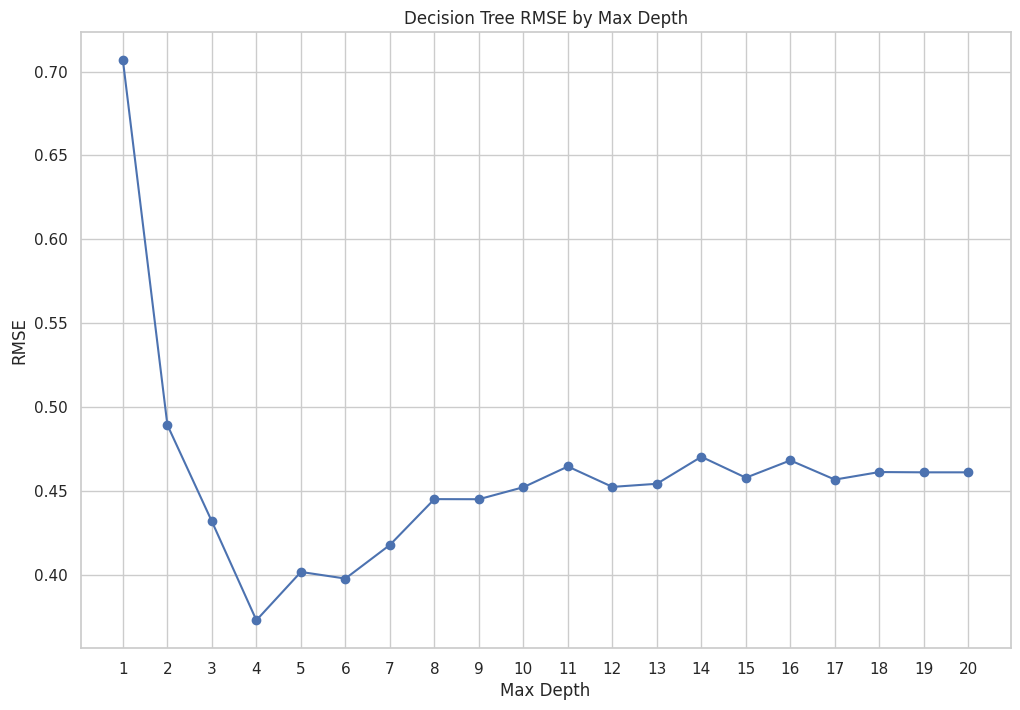

In [68]:
plt.figure(figsize=(12, 8))
plt.plot(max_depth_range, rmse_list, marker='o', linestyle='-')
plt.title('Decision Tree RMSE by Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.xticks(max_depth_range)
plt.grid(True)

Initially, as the depth increases from 1 to 4, there is a sharp decline in RMSE, indicating that the model is gaining information and becoming more accurate in its predictions.

After the depth of 4, the RMSE increase a little bit and become stable even as the depth increases to 20. This suggests that increasing the tree depth beyond the optimal point doesn't significantly improve the model's performance on the test data.

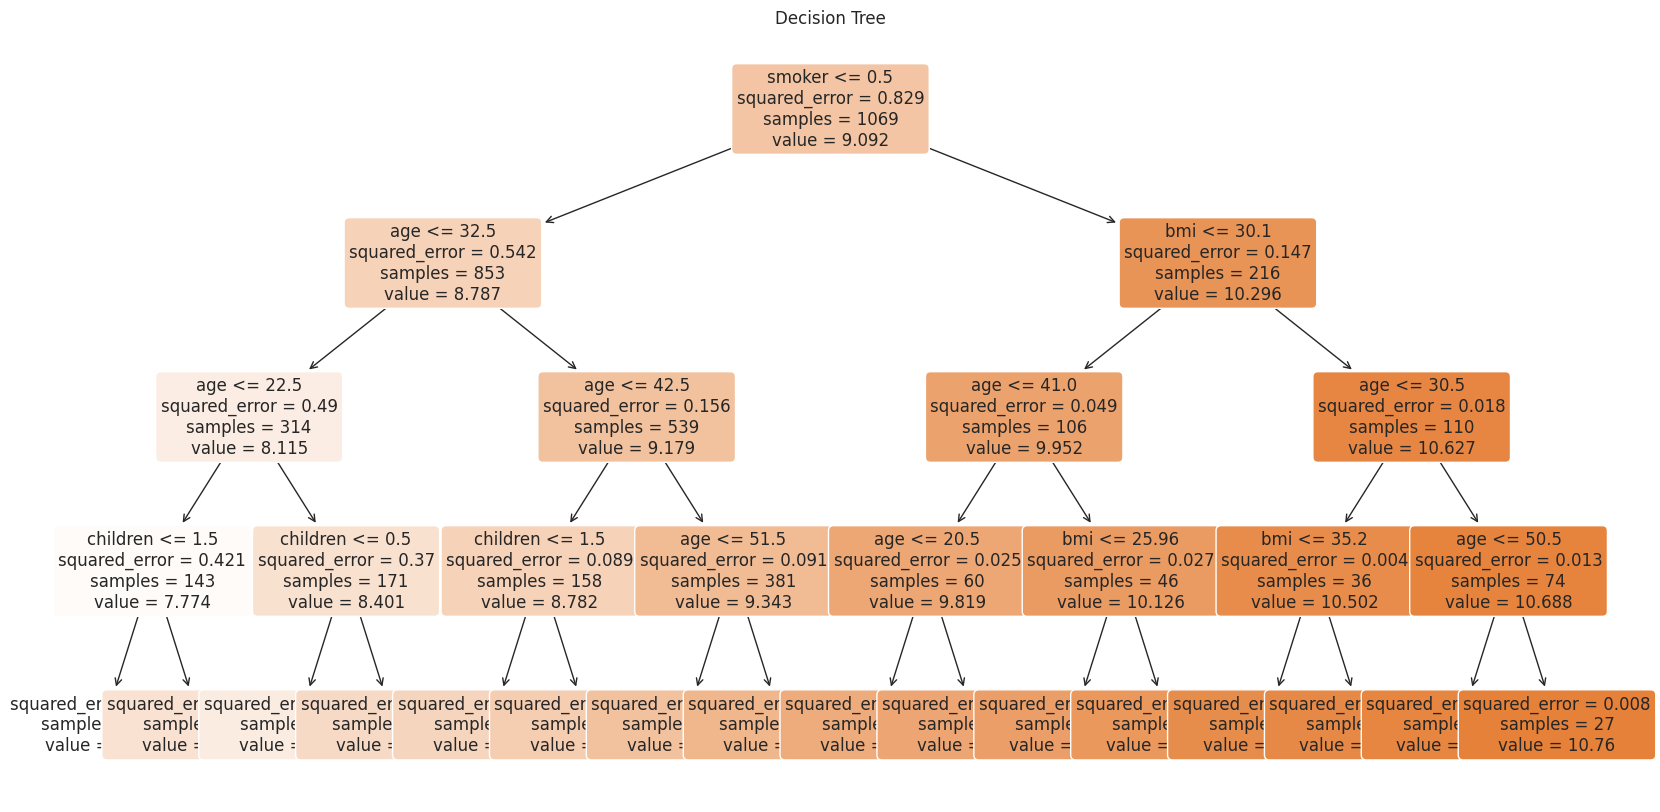

In [69]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(decision_tree_best,
          feature_names=x_train.columns,
          filled=True,
          rounded=True,
          max_depth=4,
          fontsize=12)
plt.title("Decision Tree")
plt.show()

This optimal decision tree only uses 4 of the features: smoker, age, bmi, children. This indicates that the data has a relatively simple structure and that a more complex model isn't necessary.

# Model 6: SVM

## Model building: different kernel

In [70]:
from sklearn.svm import SVR

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
best_kernel = None
min_rmse = np.inf
rmse_scores = {}

start = time.time()
for kernel in kernels:
    svm_regressor = SVR(kernel=kernel)
    svm_regressor.fit(x_train_scaled, y_train_scaled)
    y_pred_svm = svm_regressor.predict(x_test_scaled)
    mse_svm = mean_squared_error(y_test_scaled, y_pred_svm)
    rmse_svm = np.sqrt(mse_svm)
    rmse_scores[kernel] = rmse_svm

    if rmse_svm < min_rmse:
        min_rmse = rmse_svm
        best_kernel = kernel
end = time.time()

## Model performance

In [71]:
print(f"Best SVM kernel: {best_kernel} with RMSE: {min_rmse}")

for kernel, rmse in rmse_scores.items():
    print(f"{kernel} kernel RMSE: {rmse}")

Best SVM kernel: rbf with RMSE: 0.39635358622482475
linear kernel RMSE: 0.5181143848591302
poly kernel RMSE: 0.4051402790317592
rbf kernel RMSE: 0.39635358622482475
sigmoid kernel RMSE: 4.8361332844950535


In [72]:
rmse_dict['SVM (Basic)'] = min_rmse
print(rmse_dict)

{'KNN (Best)': 0.47328690662292594, 'Linear Regression (Basic)': 0.4977476403713619, 'Linear Regression (Best)': 0.48610668259607354, 'Ridge Regression (Basic)': 0.49774764358210977, 'Ridge Regression (Best)': 0.48599024582799044, 'Lasso Regression (Basic)': 0.49777333349650704, 'Lasso Regression (Best)': 0.4861066910021624, 'Decision Tree (Best)': 0.3728060475004334, 'SVM (Basic)': 0.39635358622482475}


In [73]:
time_svm = end - start
print(f"Total running time: {time_svm} seconds")
time_dict['SVM (Basic)'] = time_svm
print(time_dict)

Total running time: 0.4058394432067871 seconds
{'KNN (Best)': 6.10406494140625, 'Linear Regression (Basic)': 0.02073955535888672, 'Linear Regression (Best)': 0.7364132404327393, 'Ridge Regression (Basic)': 0.38298583030700684, 'Ridge Regression (Best)': 21.381205797195435, 'Lasso Regression (Basic)': 0.08808469772338867, 'Lasso Regression (Best)': 1.701885461807251, 'Decision Tree (Best)': 0.21225810050964355, 'SVM (Basic)': 0.4058394432067871}


([<matplotlib.axis.XTick at 0x781d92aea0b0>,
 [Text(0.0, 0, 'rbf'),
  Text(1.0, 0, 'poly'),
  Text(2.0, 0, 'linear'),
  Text(3.0, 0, 'sigmoid')])

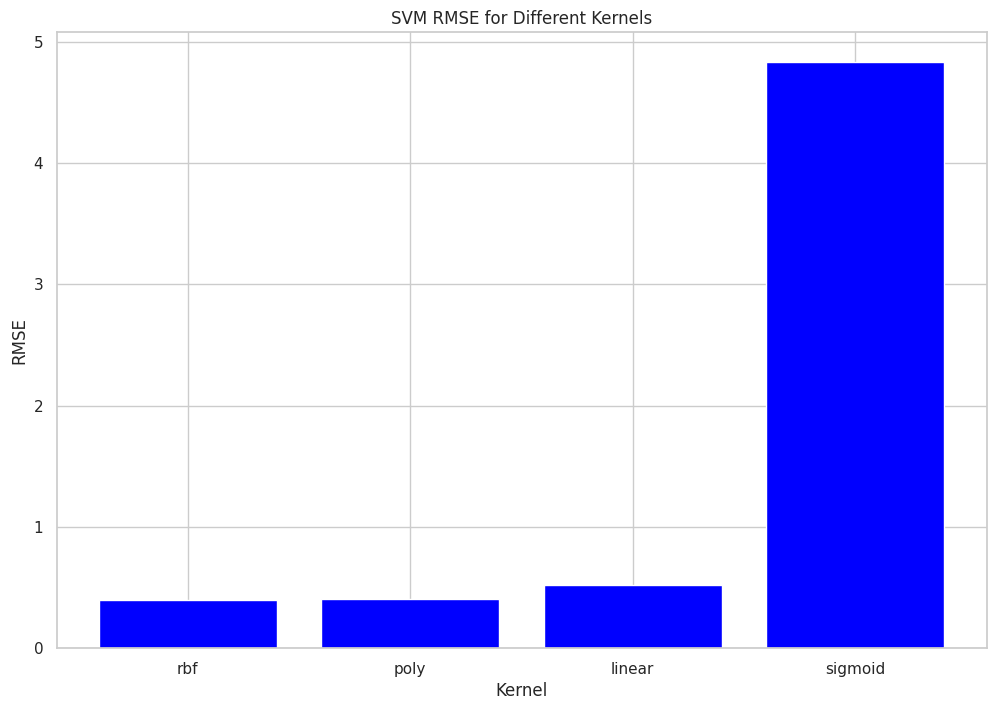

In [74]:
sorted_kernels = sorted(rmse_scores.items(), key=lambda item: item[1])

sorted_kernel_names = [k for k, v in sorted_kernels]
sorted_rmse_values = [v for k, v in sorted_kernels]

plt.figure(figsize=(12, 8))
plt.bar(sorted_kernel_names, sorted_rmse_values, color='blue')

plt.title('SVM RMSE for Different Kernels')
plt.xlabel('Kernel')
plt.ylabel('RMSE')
plt.xticks(sorted_kernel_names)

The SVM with the radial basis function (rbf) kernel achieved the best performance on this dataset. This suggests that the non-linear decision boundary created by the rbf kernel is well-suited to your data, allowing for better capturing of the underlying patterns compared to the linear decision boundary.

The sigmoid kernel performed poorly, with an RMSE of approximately 4.836, which is much higher than the other kernels. The sigmoid kernel, which resembles a neural network activation function, is not commonly used for SVM regression and might lead to erratic behavior if the data is not within a specific range or if the kernel is not properly tuned.

# Comparison: RMSE and Runtime

In [75]:
print("RMSE:")
for model, rmse in rmse_dict.items():
    print(f"Model: {model}, RMSE = {rmse}")

RMSE:
Model: KNN (Best), RMSE = 0.47328690662292594
Model: Linear Regression (Basic), RMSE = 0.4977476403713619
Model: Linear Regression (Best), RMSE = 0.48610668259607354
Model: Ridge Regression (Basic), RMSE = 0.49774764358210977
Model: Ridge Regression (Best), RMSE = 0.48599024582799044
Model: Lasso Regression (Basic), RMSE = 0.49777333349650704
Model: Lasso Regression (Best), RMSE = 0.4861066910021624
Model: Decision Tree (Best), RMSE = 0.3728060475004334
Model: SVM (Basic), RMSE = 0.39635358622482475


In [76]:
print("Runtime:")
for model, time in time_dict.items():
    print(f"Model: {model}, Runtime = {time} seconds")

Runtime:
Model: KNN (Best), Runtime = 6.10406494140625 seconds
Model: Linear Regression (Basic), Runtime = 0.02073955535888672 seconds
Model: Linear Regression (Best), Runtime = 0.7364132404327393 seconds
Model: Ridge Regression (Basic), Runtime = 0.38298583030700684 seconds
Model: Ridge Regression (Best), Runtime = 21.381205797195435 seconds
Model: Lasso Regression (Basic), Runtime = 0.08808469772338867 seconds
Model: Lasso Regression (Best), Runtime = 1.701885461807251 seconds
Model: Decision Tree (Best), Runtime = 0.21225810050964355 seconds
Model: SVM (Basic), Runtime = 0.4058394432067871 seconds


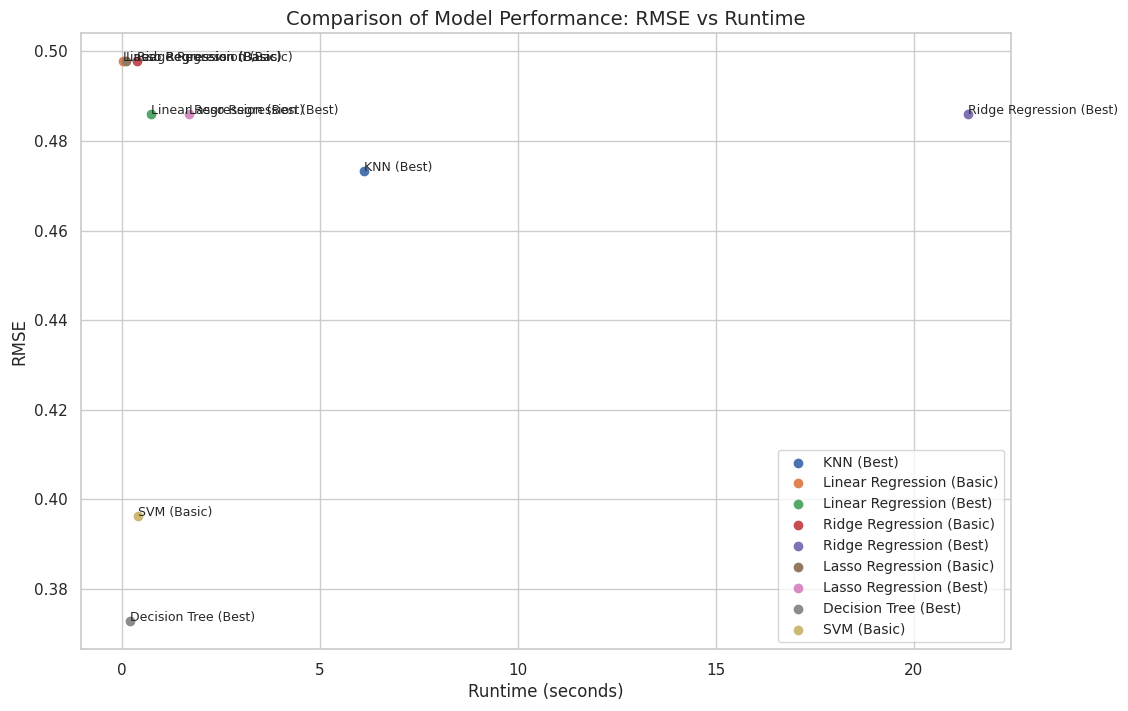

In [77]:
models = list(rmse_dict.keys())
rmse_values = [rmse_dict[model] for model in models]
time_values = [time_dict[model] for model in models]

plt.figure(figsize=(12, 8))
for i, model in enumerate(models):
    plt.scatter(time_values[i], rmse_values[i], label=model)
    plt.text(time_values[i], rmse_values[i], f'{model}', fontsize=9)

plt.xlabel('Runtime (seconds)', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('Comparison of Model Performance: RMSE vs Runtime', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)
plt.show()

**Predictive Performance (RMSE)**:

**Best Performance**: The Decision Tree model had the best performance with the lowest RMSE of 0.3728, suggesting it was able to capture the underlying patterns in the dataset very effectively.

**Competitive Models**: The SVM model also showed strong performance with an RMSE of 0.3964, which is notable since SVM is a powerful algorithm capable of handling complex non-linear relationships.

**Enhanced Linear Models**: Both Ridge and Lasso regression with the best hyperparameters outperformed basic Linear Regression, showing the benefit of regularization in potentially reducing overfitting and improving model performance.

**Basic Models**: Basic Linear Regression, Ridge, and Lasso all had similar RMSEs when no parameter tuning was applied, which indicates that without tuning, these models have comparable performance on the dataset.

**Computational Efficiency (Runtime)**:

**Fastest Model**: Basic Linear Regression had an extremely fast runtime of approximately 0.004 seconds, which is expected given the simplicity of the model.

**Most Time-consuming**: Ridge Regression with the best settings took the longest time (12.4 seconds), which might be due to the process of hyperparameter tuning.

**Balance of Speed and Performance**: The KNN model, while having the second-best RMSE, had a moderate runtime, making it a potentially good choice if both accuracy and speed are considerations.

**Quick Decision Trees**: The Decision Tree model, despite its superior RMSE, had a relatively quick runtime of 0.260 seconds, making it highly efficient.

**Moderate Performers**: SVM and the best Lasso Regression models had moderate runtimes, but they still provided good accuracy, suggesting a reasonable trade-off between runtime and performance.

**Overall Assessment**:

The Decision Tree stands out for its high accuracy and reasonable computation time, followed closely by SVM, which also offers good accuracy with a slightly higher computation time. Regularized linear models (Ridge and Lasso) with optimal parameters show that hyperparameter tuning can improve the performance of linear models to be competitive with more complex models like SVM.

# Future work

## Feature selection: backward elimination VS forward selection

Among all 6 models I created, we can notice that the best model (with smallest RMSE) I get is a decision tree with a depth of 4, which is relatively small. It only uses 4 of the features out of all 9 features: smoker, age, bmi, children. This indicates that the data has a relatively simple structure and that a more complex model probably isn't necessary.

In some of the other models, I use **backward elimination** to do feature selection, but they only removes 1 or 2 features, so they are still using more features compared to the decision tree here. So, instead of backward elimination, I should probably also try **forward selection** - begins with an empty model and adds in variables one by one. By using this, the performance of these other models might become better.

Additionaly, I may try to generate all possible combinations of features, and apply all models to them. This will probably find some even better models. However, sine there are lots of combinations, running time will increase a lot.

## GridSearchCV: Hyperparameter tuning and Cross validation

After I finished building all 6 models, I discovered a useful model selection module I can use in sklearn:

In [78]:
from sklearn.model_selection import GridSearchCV

 This module is highly beneficial. Its utility stems from the combination of hyperparameter tuning with cross-validation, enhancing the model selection process. In my future work, I should use this in all the models I build, to find better models. Previously, the optimization of my models was limited to iterative loops that manually adjusted one or two hyperparameters. However, GridSearchCV offers a more sophisticated and systematic approach, enabling the simultaneous exploration of multiple hyperparameter dimensions.

## More...

I only applied 6 models in this project, while there are lots of powerful models undiscovered for me, such as neural network. In my future work, I should try to explore and apply more of them onto the dataset. I believe that advanced models like neural network will definitely outperforms most or all of the models I have now. To do this, I need to learn more, and spend more time. The exploration of the world of machine learning is challenging and endless, and also interesting and attractive.

# Reference

Used ChatGPT for assistance.

EDA & Regression: https://www.kaggle.com/code/mariapushkareva/medical-insurance-cost-with-linear-regression

KNN: https://www.kaggle.com/code/shakthishivani/insurance-premiun-prediction-knn

Preprocessing of data: https://mlquant.notion.site/E-Preprocessing-Phase-3d631fbb122b484db73d0edfe7f63136
